**Install libraries**



In [14]:
!pip install -q prophet chronos-forecasting statsmodels


**Create dummy supply chain data (~6000 rows)**

In [15]:
import numpy as np
import pandas as pd

# 1. Create date range (~6000 days ≈ 16.4 years)
dates = pd.date_range(start="2010-01-01", periods=6000, freq="D")

n = len(dates)
rng = np.random.default_rng(42)

# 2. Base demand + slight upward trend
base = 100
trend = np.linspace(0, 30, n)  # slowly increasing demand

# 3. Weekly seasonality (higher demand on weekends)
day_of_week = dates.dayofweek  # 0=Mon, 6=Sun
weekly_pattern = np.where(day_of_week >= 5, 20, 0)  # +20 on Sat/Sun

# 4. Promo flag (randomly choose ~10% of days as promotions)
promo_flag = (rng.random(n) < 0.10).astype(int)
promo_effect = promo_flag * 30  # bump when promo is on

# 5. Holiday flag (two fixed days each year: Jan 26, Aug 15)
holiday_dates = []
for year in range(dates.min().year, dates.max().year + 1):
    holiday_dates += [
        f"{year}-01-26",  # Republic Day (example)
        f"{year}-08-15",  # Independence Day (example)
    ]
holidays = pd.to_datetime(holiday_dates)

holiday_flag = dates.isin(holidays).astype(int)
holiday_effect = holiday_flag * 50

# 6. Random noise
noise = rng.normal(0, 10, n)

# 7. Final demand (clip to avoid negative)
demand = base + trend + weekly_pattern + promo_effect + holiday_effect + noise
demand = np.clip(demand, a_min=1, a_max=None)

# 8. Build DataFrame
df = pd.DataFrame({
    "ds": dates,
    "y": demand.round(0).astype(int),
    "promo_flag": promo_flag,
    "holiday_flag": holiday_flag,
})

print("Number of rows:", len(df))
df.head()


Number of rows: 6000


,ds,y,promo_flag,holiday_flag
0,2010-01-01,90,0,0
1,2010-01-02,125,0,0
2,2010-01-03,114,0,0
3,2010-01-04,84,0,0
4,2010-01-05,127,1,0


**Train–test split + metrics**

Train period: 2010-01-01 00:00:00 → 2023-02-21 00:00:00
Test period : 2023-02-22 00:00:00 → 2026-06-05 00:00:00
Train size: 4800 Test size: 1200


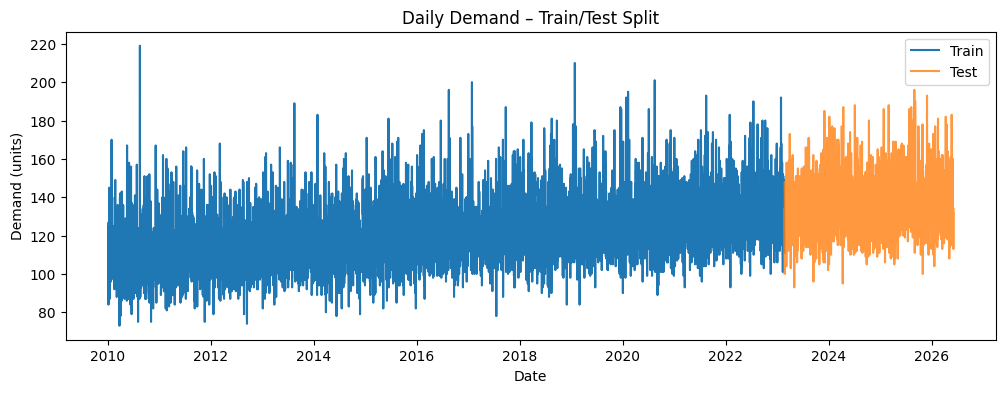

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Set datetime index for easier time-based operations
df_idx = df.set_index("ds").copy()

# 2. Train–test split (80% train, 20% test by time)
split_point = int(len(df_idx) * 0.8)
split_date = df_idx.index[split_point]

train = df_idx.iloc[:split_point].copy()
test = df_idx.iloc[split_point:].copy()

print("Train period:", train.index.min(), "→", train.index.max())
print("Test period :", test.index.min(), "→", test.index.max())
print("Train size:", len(train), "Test size:", len(test))

# 3. Simple metric functions
def rmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(
        np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))
    ) * 100

y_test = test["y"].values

# 4. Quick plot to visualize train vs test split
plt.figure(figsize=(12, 4))
plt.plot(train.index, train["y"], label="Train")
plt.plot(test.index, test["y"], label="Test", alpha=0.8)
plt.title("Daily Demand – Train/Test Split")
plt.xlabel("Date")
plt.ylabel("Demand (units)")
plt.legend()
plt.show()


**SARIMAX baseline (statsmodels)**

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX – RMSE: 10.16, MAPE: 6.08%


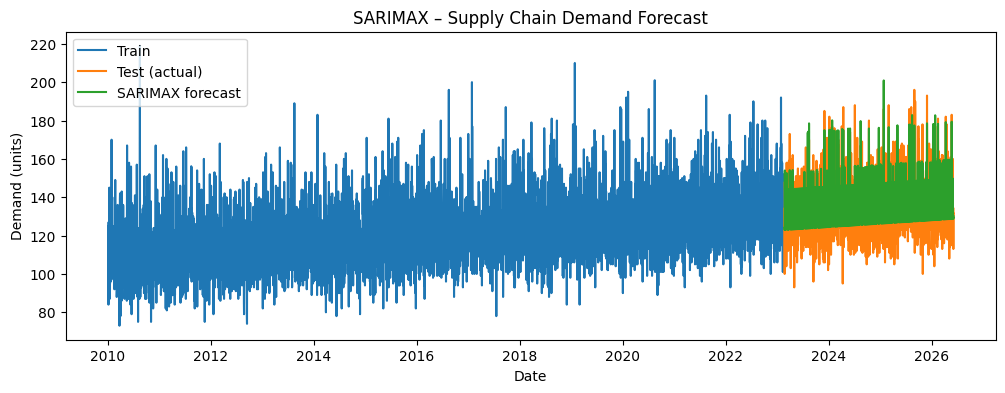

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Exogenous variables for train and test
exog_cols = ["promo_flag", "holiday_flag"]
exog_train = train[exog_cols]
exog_test = test[exog_cols]

# 2. Define SARIMAX model
# ARIMA(1,1,1) + seasonal(1,1,1,7) to capture weekly pattern
sarimax_model = SARIMAX(
    endog=train["y"],
    exog=exog_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

# 3. Fit the model
sarimax_result = sarimax_model.fit(disp=False)

# 4. Forecast over the test horizon
forecast_res = sarimax_result.get_forecast(
    steps=len(test),
    exog=exog_test
)
sarimax_pred = forecast_res.predicted_mean.values

# 5. Evaluate
sarimax_rmse = rmse(y_test, sarimax_pred)
sarimax_mape = mape(y_test, sarimax_pred)

print(f"SARIMAX – RMSE: {sarimax_rmse:.2f}, MAPE: {sarimax_mape:.2f}%")

# 6. Plot
plt.figure(figsize=(12, 4))
plt.plot(train.index, train["y"], label="Train")
plt.plot(test.index, test["y"], label="Test (actual)")
plt.plot(test.index, sarimax_pred, label="SARIMAX forecast")
plt.title("SARIMAX – Supply Chain Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Demand (units)")
plt.legend()
plt.show()


**Bayesian search for SARIMAX (with Optuna)**

In [18]:
# Bayesian hyperparameter search for SARIMAX using Optuna
!pip install -q optuna

import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX

# We will tune (p,d,q) and (P,D,Q) for weekly seasonality=7
# NOTE: This uses the current train/test you already defined:
#   train, test, exog_train, exog_test, y_test, mape()

def objective(trial):
    # Search space (keep small so it runs fast)
    p = trial.suggest_int("p", 0, 2)
    d = trial.suggest_int("d", 0, 1)
    q = trial.suggest_int("q", 0, 2)

    P = trial.suggest_int("P", 0, 1)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 1)

    order = (p, d, q)
    seasonal_order = (P, D, Q, 7)   # 7 = weekly seasonality

    try:
        model = SARIMAX(
            endog=train["y"],
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        result = model.fit(disp=False)

        # forecast on the same test horizon
        forecast_res = result.get_forecast(steps=len(test), exog=exog_test)
        pred = forecast_res.predicted_mean.values

        # objective: minimize MAPE on test
        return mape(y_test, pred)

    except Exception:
        # if model fails to fit, give a very bad score
        return float("inf")


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("Best params:", study.best_params)
print("Best MAPE :", study.best_value)


[I 2025-11-22 09:50:03,738] A new study created in memory with name: no-name-96a0326d-675c-41b0-9faf-d86d694a1117


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2025-11-22 09:50:13,974] Trial 0 finished with value: 49.57552349968422 and parameters: {'p': 0, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 0}. Best is trial 0 with value: 49.57552349968422.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[I 2025-11-22 09:50:24,269] Trial 1 finished with value: 15.371191867081322 and parameters: {'p': 1, 'd': 0, 'q': 2, 'P': 1, 'D': 0, 'Q': 1}. Best is trial 1 with value: 15.371191867081322.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2025-11-22 09:50:30,639] Trial 2 finished with value: 15.36327481806243 and parameters: {'p': 0, 'd': 0, 'q': 0, 'P': 1, 'D': 0, 'Q': 1}. Best is trial 2 with value: 15.36327481806243.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2025-11-22 09:50:41,638] Trial 3 finished with value: 39.224384133913574 and parameters: {'p': 1, 'd': 0, 'q': 0, 'P': 1, 'D': 0, 'Q': 0}. Best is trial 2 with value: 15.36327481806243.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2025-11-22 09:50:57,206] Trial 4 finished with value: 97.65847935823896 and parameters: {'p': 0, 'd': 0, 'q': 2, 'P': 0, 'D': 0, 'Q': 0}. Best is trial 2 with value: 15.36327481806243.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2025-11-22 09:51:07,116] Trial 5 finished with value: 94.10726387855622 and parameters: {'p': 1, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 1}. Best is trial 2 with value: 15.36327481806243.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[I 2025-11-22 09:51:15,180] Trial 6 finished with value: 6.317003474442802 and parameters: {'p': 0, 'd': 0, 'q': 1, 'P': 1, 'D': 1, 'Q': 1}. Best is trial 6 with value: 6.317003474442802.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[I 2025-11-22 09:51:17,958] Trial 7 finished with value: 6.908807250345096 and parameters: {'p': 0, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 0}. Best is trial 6 with value: 6.317003474442802.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[I 2025-11-22 09:51:30,434] Trial 8 finished with value: 6.318916910292815 and parameters: {'p': 2, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 1}. Best is trial 6 with value: 6.317003474442802.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[I 2025-11-22 09:51:35,590] Trial 9 finished with value: 8.157359992384503 and parameters: {'p': 2, 'd': 1, 'q': 1, 'P': 0, 'D': 0, 'Q': 0}. Best is trial 6 with value: 6.317003474442802.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[I 2025-11-22 09:51:53,737] Trial 10 finished with value: 6.075751659072129 and parameters: {'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 1}. Best is trial 10 with value: 6.075751659072129.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[I 2025-11-22 09:52:10,851] Trial 11 finished with value: 6.075751659072129 and parameters: {'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 1}. Best is trial 10 with value: 6.075751659072129.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[I 2025-11-22 09:52:27,787] Trial 12 finished with value: 6.075751659072129 and parameters: {'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 1}. Best is trial 10 with value: 6.075751659072129.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2025-11-22 09:53:04,545] Trial 13 finished with value: 6.0828669931612644 and parameters: {'p': 1, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 1}. Best is trial 10 with value: 6.075751659072129.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[I 2025-11-22 09:53:21,642] Trial 14 finished with value: 6.075751659072129 and parameters: {'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 1}. Best is trial 10 with value: 6.075751659072129.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[I 2025-11-22 09:53:44,199] Trial 15 finished with value: 6.075617638049166 and parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 1}. Best is trial 15 with value: 6.075617638049166.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[I 2025-11-22 09:54:10,212] Trial 16 finished with value: 6.075516718822166 and parameters: {'p': 2, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 1}. Best is trial 16 with value: 6.075516718822166.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2025-11-22 09:54:48,876] Trial 17 finished with value: 6.2881614045233905 and parameters: {'p': 2, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 1}. Best is trial 16 with value: 6.075516718822166.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2025-11-22 09:55:30,925] Trial 18 finished with value: 6.2881614045233905 and parameters: {'p': 2, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 1}. Best is trial 16 with value: 6.075516718822166.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[I 2025-11-22 09:55:53,455] Trial 19 finished with value: 6.075617638049166 and parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 1}. Best is trial 16 with value: 6.075516718822166.
Best params: {'p': 2, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 1}
Best MAPE : 6.075516718822166


**Refit SARIMAX with the best hyperparameters**

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Tuned SARIMAX – RMSE: 10.16, MAPE: 6.08%


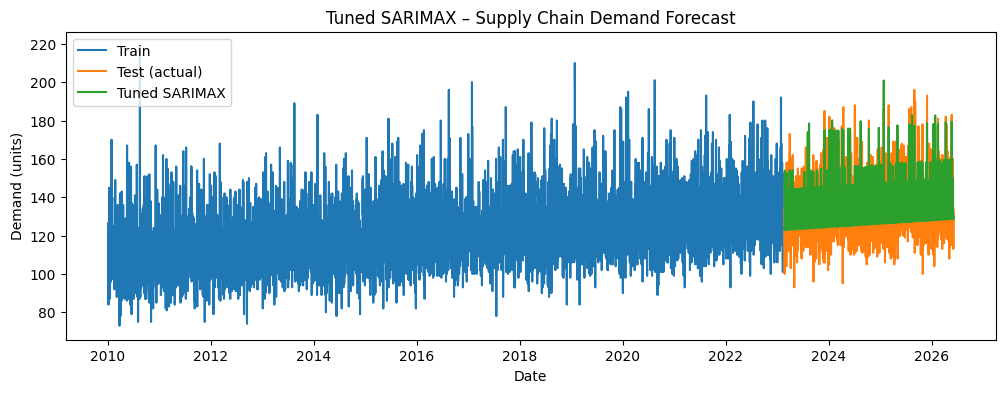

In [19]:
best = study.best_params

best_model = SARIMAX(
    endog=train["y"],
    exog=exog_train,
    order=(best["p"], best["d"], best["q"]),
    seasonal_order=(best["P"], best["D"], best["Q"], 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

best_result = best_model.fit(disp=False)
best_forecast = best_result.get_forecast(steps=len(test), exog=exog_test)
best_pred = best_forecast.predicted_mean.values

best_rmse = rmse(y_test, best_pred)
best_mape = mape(y_test, best_pred)

print(f"Tuned SARIMAX – RMSE: {best_rmse:.2f}, MAPE: {best_mape:.2f}%")

plt.figure(figsize=(12, 4))
plt.plot(train.index, train["y"], label="Train")
plt.plot(test.index, test["y"], label="Test (actual)")
plt.plot(test.index, best_pred, label="Tuned SARIMAX")
plt.title("Tuned SARIMAX – Supply Chain Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Demand (units)")
plt.legend()
plt.show()


**Prophet model**

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 101.7 MB/s eta 0:00:00
Prophet – RMSE: 10.22, MAPE: 6.15%


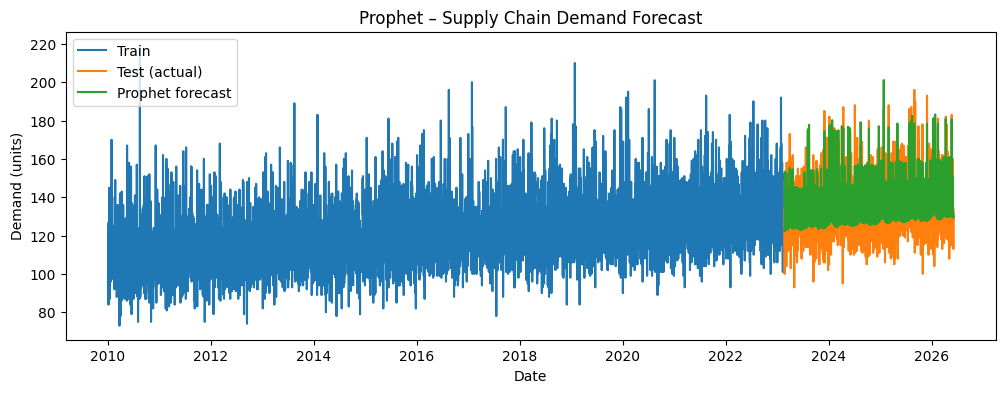

In [20]:
# 0) Clean install: remove any existing Prophet + cmdstanpy
!pip uninstall -y prophet cmdstanpy -q
!pip install -q prophet

from prophet import Prophet
import matplotlib.pyplot as plt

# 1) Prepare train and test for Prophet (needs 'ds' and 'y')
#    (train and test already created in earlier cells)
train_p = train.reset_index()   # columns: ds, y, promo_flag, holiday_flag
test_p = test.reset_index()

# 2) Define Prophet model
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
)

# Add regressors for promos and holidays
m.add_regressor("promo_flag")
m.add_regressor("holiday_flag")

# 3) Fit model on train data
m.fit(train_p[["ds", "y", "promo_flag", "holiday_flag"]])

# 4) Build future dataframe for test horizon with same regressors
future = test_p[["ds", "promo_flag", "holiday_flag"]].copy()

# 5) Forecast
forecast = m.predict(future)

# 6) Get predictions and evaluate
prophet_pred = forecast["yhat"].values

prophet_rmse = rmse(y_test, prophet_pred)
prophet_mape = mape(y_test, prophet_pred)

print(f"Prophet – RMSE: {prophet_rmse:.2f}, MAPE: {prophet_mape:.2f}%")

# 7) Plot
plt.figure(figsize=(12, 4))
plt.plot(train.index, train["y"], label="Train")
plt.plot(test.index, test["y"], label="Test (actual)")
plt.plot(test.index, prophet_pred, label="Prophet forecast")
plt.title("Prophet – Supply Chain Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Demand (units)")
plt.legend()
plt.show()

**Optuna + Prophet tuning**

In [21]:
!pip install -q optuna

import optuna
from prophet import Prophet

def prophet_objective(trial):
    # Hyperparameters to tune
    changepoint_prior_scale = trial.suggest_float("changepoint_prior_scale", 0.01, 0.5, log=True)
    seasonality_prior_scale = trial.suggest_float("seasonality_prior_scale", 1.0, 20.0)
    seasonality_mode = trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"])

    # Build a Prophet model with these hyperparameters
    m_tuned = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
    )
    m_tuned.add_regressor("promo_flag")
    m_tuned.add_regressor("holiday_flag")

    # Fit on train
    m_tuned.fit(train_p[["ds", "y", "promo_flag", "holiday_flag"]])

    # Forecast on test horizon
    future = test_p[["ds", "promo_flag", "holiday_flag"]].copy()
    forecast = m_tuned.predict(future)

    pred = forecast["yhat"].values

    # Objective: minimize MAPE on test set
    return mape(y_test, pred)

# Run a small Bayesian search (you can increase n_trials if you want)
study_prophet = optuna.create_study(direction="minimize")
study_prophet.optimize(prophet_objective, n_trials=15, show_progress_bar=True)

print("Best Prophet params:", study_prophet.best_params)
print("Best Prophet MAPE :", study_prophet.best_value)


[I 2025-11-22 09:58:34,367] A new study created in memory with name: no-name-48630b30-2140-434b-a2ec-14bbf66759c1


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-11-22 09:58:38,354] Trial 0 finished with value: 6.229643132232162 and parameters: {'changepoint_prior_scale': 0.40071392718686816, 'seasonality_prior_scale': 9.379790928039245, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 6.229643132232162.
[I 2025-11-22 09:58:39,414] Trial 1 finished with value: 6.131057017254888 and parameters: {'changepoint_prior_scale': 0.02691194921514311, 'seasonality_prior_scale': 12.691209429942713, 'seasonality_mode': 'additive'}. Best is trial 1 with value: 6.131057017254888.
[I 2025-11-22 09:58:40,436] Trial 2 finished with value: 6.173575217823604 and parameters: {'changepoint_prior_scale': 0.011547502888527723, 'seasonality_prior_scale': 2.529701105145759, 'seasonality_mode': 'multiplicative'}. Best is trial 1 with value: 6.131057017254888.
[I 2025-11-22 09:58:41,408] Trial 3 finished with value: 6.141840537529203 and parameters: {'changepoint_prior_scale': 0.0467271945278008, 'seasonality_prior_scale': 17.878546394867474, 's

**Refit Prophet with best params**

Tuned Prophet – RMSE: 10.20, MAPE: 6.12%
Manual Prophet MAPE: 6.154387618416546


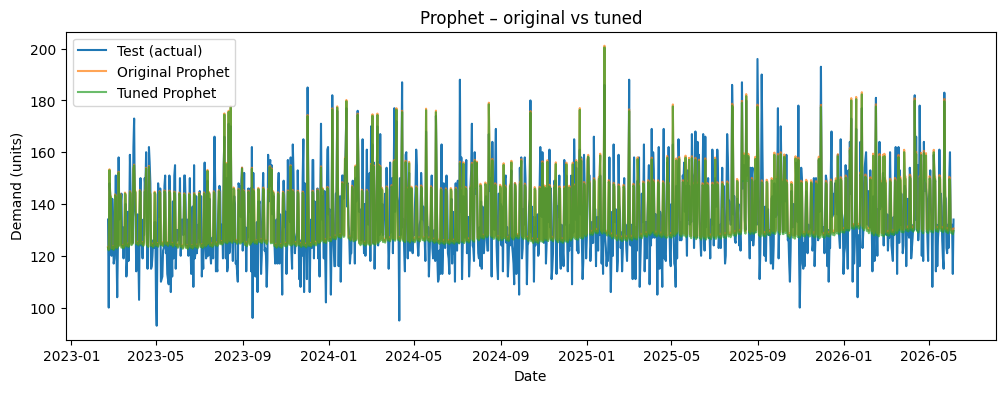

In [22]:
best_p = study_prophet.best_params

m_best_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best_p["changepoint_prior_scale"],
    seasonality_prior_scale=best_p["seasonality_prior_scale"],
    seasonality_mode=best_p["seasonality_mode"],
)
m_best_prophet.add_regressor("promo_flag")
m_best_prophet.add_regressor("holiday_flag")

m_best_prophet.fit(train_p[["ds", "y", "promo_flag", "holiday_flag"]])

future = test_p[["ds", "promo_flag", "holiday_flag"]].copy()
forecast_best = m_best_prophet.predict(future)
prophet_best_pred = forecast_best["yhat"].values

prophet_best_rmse = rmse(y_test, prophet_best_pred)
prophet_best_mape = mape(y_test, prophet_best_pred)

print(f"Tuned Prophet – RMSE: {prophet_best_rmse:.2f}, MAPE: {prophet_best_mape:.2f}%")
print("Manual Prophet MAPE:", prophet_mape)

plt.figure(figsize=(12, 4))
plt.plot(test.index, test["y"], label="Test (actual)")
plt.plot(test.index, prophet_pred, label="Original Prophet", alpha=0.7)
plt.plot(test.index, prophet_best_pred, label="Tuned Prophet", alpha=0.7)
plt.title("Prophet – original vs tuned")
plt.xlabel("Date")
plt.ylabel("Demand (units)")
plt.legend()
plt.show()


**Chronos-2**

Context shape: (4800, 5)
Future covariates shape: (1200, 4)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/chronos/chronos2/pipeline.py:514: UserWarning: We recommend keeping prediction length <= 1024. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Chronos-2 – RMSE: 10.84, MAPE: 6.29%


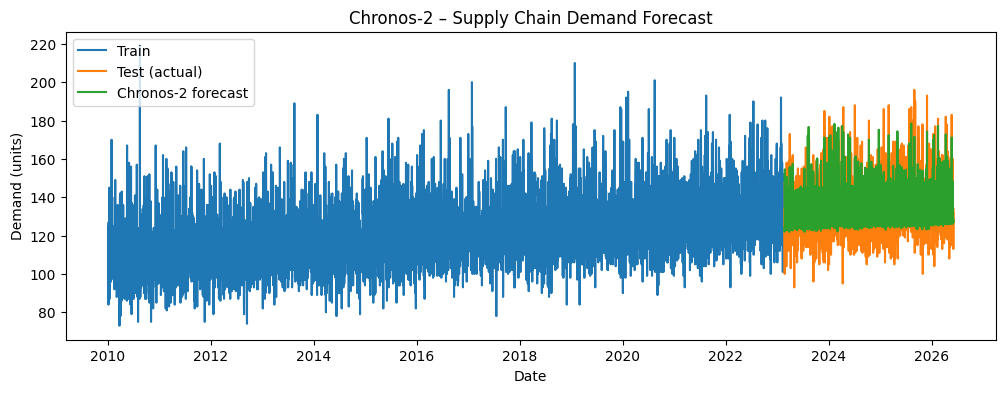

In [23]:
# 0) Install Chronos + optional pyarrow for pandas
!pip install -q "chronos-forecasting>=2.0" "pandas[pyarrow]"

import pandas as pd
import matplotlib.pyplot as plt
from chronos import Chronos2Pipeline

# 1) Build context (train) and future covariates (test) for Chronos-2
#    Our train/test currently have index=ds and columns: y, promo_flag, holiday_flag

context_df = train.reset_index().rename(columns={"ds": "timestamp", "y": "target"})
context_df["id"] = "sku_A123"
context_df = context_df[["id", "timestamp", "target", "promo_flag", "holiday_flag"]]

future_df = test.reset_index().rename(columns={"ds": "timestamp", "y": "target"})
future_df["id"] = "sku_A123"
# For future_df we drop the target column (we're only providing covariates)
future_cov_df = future_df[["id", "timestamp", "promo_flag", "holiday_flag"]]

print("Context shape:", context_df.shape)
print("Future covariates shape:", future_cov_df.shape)

# 2) Load Chronos-2 pipeline
#    device_map="auto" → uses GPU if available, otherwise CPU.
#    If this is too heavy, you can try a smaller model like "amazon/chronos-bolt-small".
pipeline = Chronos2Pipeline.from_pretrained(
    "amazon/chronos-2",
    device_map="auto",
)

# 3) Forecast with Chronos-2
prediction_length = len(test)

pred_df = pipeline.predict_df(
    context_df,
    future_df=future_cov_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column="id",
    timestamp_column="timestamp",
    target="target",
)

# 4) Extract predictions for our single id
pred_df_single = pred_df[pred_df["id"] == "sku_A123"].sort_values("timestamp")

chronos_pred = pred_df_single["predictions"].values

# 5) Evaluate
chronos_rmse = rmse(y_test, chronos_pred)
chronos_mape = mape(y_test, chronos_pred)

print(f"Chronos-2 – RMSE: {chronos_rmse:.2f}, MAPE: {chronos_mape:.2f}%")

# 6) Plot
plt.figure(figsize=(12, 4))
plt.plot(train.index, train["y"], label="Train")
plt.plot(test.index, test["y"], label="Test (actual)")
plt.plot(test.index, chronos_pred, label="Chronos-2 forecast")
plt.title("Chronos-2 – Supply Chain Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Demand (units)")
plt.legend()
plt.show()


**Final metrics table**

In [24]:
# Final comparison table
results = pd.DataFrame({
    "Model": [
        "SARIMAX (statsmodels)",
        "Prophet",
        "Chronos-2",
    ],
    "RMSE": [
        sarimax_rmse,
        prophet_rmse,
        chronos_rmse,
    ],
    "MAPE (%)": [
        sarimax_mape,
        prophet_mape,
        chronos_mape,
    ],
})

results.sort_values("MAPE (%)").reset_index(drop=True)


,Model,RMSE,MAPE (%)
0,SARIMAX (statsmodels),10.158017,6.076174
1,Prophet,10.217211,6.154388
2,Chronos-2,10.835744,6.291878


**tuned final comparison**

In [25]:
results_tuned = pd.DataFrame({
    "Model": [
        "SARIMAX (manual)",
        "SARIMAX (tuned)",
        "Prophet (manual)",
        "Prophet (tuned)",
        "Chronos-2",
    ],
    "RMSE": [
        sarimax_rmse,
        best_rmse,
        prophet_rmse,
        prophet_best_rmse,
        chronos_rmse,
    ],
    "MAPE (%)": [
        sarimax_mape,
        best_mape,
        prophet_mape,
        prophet_best_mape,
        chronos_mape,
    ],
})

results_tuned.sort_values("MAPE (%)").reset_index(drop=True)


,Model,RMSE,MAPE (%)
0,SARIMAX (tuned),10.158053,6.075517
1,SARIMAX (manual),10.158017,6.076174
2,Prophet (tuned),10.198305,6.117338
3,Prophet (manual),10.217211,6.154388
4,Chronos-2,10.835744,6.291878
